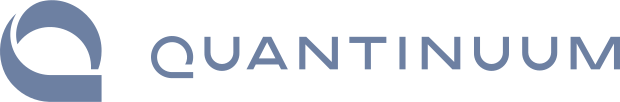
# Submitting to Quantinuum Emulators via pytket

# Quantinuum Circuit Submissions via pytket

This notebook contains basic circuit submission examples to Quantinuum quantum hardware via `pytket`.<br>
* [What is TKET?](#tket)<br>
* [Step by Step](#step-by-step)<br>
* [Additional Features](#additional-features)

## What is TKET? <a class="anchor" id="tket"></a>

The TKET framework (pronounced "ticket") is a software platform for the development and execution of gate-level quantum computation, providing state-of-the-art performance in circuit compilation. It was created and is maintained by Quantinuum. The toolset is designed to extract the most out of the available NISQ devices of today and is platform-agnostic.<br><br>
In python, the `pytket` packages are available for python 3.8+. The `pytket` and `pytket-quantinuum` packages are included as part of the installation instructions on the user portal.<br><br>
For more information on TKET, see the following links:<br>
- [TKET manual](https://cqcl.github.io/pytket/manual/manual_intro.html)<br>
- [TKET overview and demo video](https://www.youtube.com/watch?v=yXKSpvgAtrk)<br>
- [Introduction to Quantum Compilation with TKET](https://github.com/CalMacCQ/tket_blog/blob/main/blog1_intro_to_qc.ipynb)

This notebook covers how to use `pytket` in conjunction with `pytket-quantinuum` to submit to Quantinuum devices. The quantum compilation step is demonstrated, but for a full overview of quantum compilation with TKET, the last link above is recommended.<br><br>
See the links below for the `pytket` and `pytket-quantinuum` documentation:<br>
- [pytket](https://cqcl.github.io/tket/pytket/api/index.html)<br>
- [pytket-quantinuum](https://cqcl.github.io/pytket-quantinuum/api/index.html)

## Step by Step <a class="anchor" id="step-by-step"></a>

### Circuit Preparation

Create your circuit via the pytket python library. For details on getting started with `pytket`, see pytket's [Getting Started](https://cqcl.github.io/tket/pytket/api/getting_started.html) page.<br><br>
**Note**: `pytket` renders circuits in ZX-calculus notation. This can be toggled on and off by pressing the top left button.

In [ ]:
from pytket.circuit import Circuit, fresh_symbol
from pytket.circuit.display import render_circuit_jupyter

Set up Bell Test

In [ ]:
circuit = Circuit(2, name="Bell Test")
circuit.H(0)
circuit.CX(0, 1)
circuit.measure_all()
render_circuit_jupyter(circuit)

### Select Device

See the *Quantinuum Systems User Guide* in the *Examples* tab on the *Quantinuum User Portal* for information on each of the systems listed below.<br><br>
*Available machines:*<br>
- `H1-1`, `H1-2`: Quantum Computers, submit specifically to H1-1 or H1-2 by using the device name.<br>
- `H1-1E`, `H1-2E`: Device-specific Emulators of H1-1 and H1-2.<br>
- `H1-1SC`, `H1-2SC`: Device-specific Syntax Checkers, check compilation of a quantum circuit against device-specific instructions, returns `completed` if syntax is correct along with the H-Series Quantum Credits (HQCs), returns `failed` if the syntax is incorrect along with the error.<br>
- `H1`: Submit to Quantinuum System Model H1 machines, job is run on H1-1 or H1-2 based on soonest available device.

Select a machine and login to the Quantinuum API using your credentials. You will need to login once per session, in Jupyter you will get a dialogue asking for credentials, or if running a script you will be prompted at your shell. You can also [save your email in the pytket config](https://cqcl.github.io/pytket-quantinuum/api/api.html#pytket.extensions.quantinuum.backends.config.set_quantinuum_config).

In [ ]:
from pytket.extensions.quantinuum import QuantinuumBackend

In [ ]:
machine = "H1-1E"
backend = QuantinuumBackend(device_name=machine)
backend.login()

We can also check the status of a device.

In [ ]:
print(machine, "status:", QuantinuumBackend.device_state(device_name=machine))

Available devices can be viewed using the `available_devices` function. Additional information is returned, here just the device names are pulled in.

In [ ]:
[x.device_name for x in QuantinuumBackend.available_devices()]

### Circuit Compilation

`pytket` includes many features for optimizing circuits. This includes reducing the number of gates where possible and resynthesizing circuits for a quantum computer's native gate set. See the `pytket-quantinuum` [Default Compilation](https://cqcl.github.io/pytket-quantinuum/api/index.html#default-compilation) section for more information on all the options that are available for the `QuantinuumBackend`.<br><br>
Here the circuit is compiled with `get_compiled_circuit`, which includes optimizing the gates and resynthesizing the circuit to Quantinuum's native gate set. The `optimisation_level` sets the level of optimization to perform during compilation, check pytket documentation for more details.

In [ ]:
compiled_circuit = backend.get_compiled_circuit(circuit, optimisation_level=1)
render_circuit_jupyter(compiled_circuit)

### Check Circuit Cost

Before running on Quantinuum systems, it is good practice to check how many H-Series Quantum Credits (HQCs) a job will cost, in order to plan usage. In `pytket` this can be done using the `cost` function of the `QuantinuumBackend`.<br><br>
Note that in this case because an emulator is used, the specific syntax checker the emulator uses is specified. This is an optional parameter not needed if you are using a quantum computer target.

In [ ]:
n_shots = 100
backend.cost(compiled_circuit, n_shots=n_shots, syntax_checker="H1-1SC")

### Run the Circuit

Now the circuit can be run on Quantinuum systems.

In [ ]:
handle = backend.process_circuit(compiled_circuit, n_shots=n_shots)
print(handle)

The status of a submitted job can be viewed at any time, indicating if a job is in the queue or completed. Additional information is also provided, such as queue position, start time, completion time, and circuit cost in HQCs.

In [ ]:
status = backend.circuit_status(handle)
print(status)

### Retrieve Results

Once a job's status returns completed, results can be obtained using the `get_result` function.

In [ ]:
result = backend.get_result(handle)
result

### Save Results

It is recommended that users save job results as soon as jobs are completed due to the Quantinuum data retention policy.

In [ ]:
import json

In [ ]:
with open("pytket_example.json", "w") as file:
    json.dump(result.to_dict(), file)

Results can be loaded to their original format using `BackendResult.from_dict`.

In [ ]:
from pytket.backends.backendresult import BackendResult

In [ ]:
with open("pytket_example.json") as file:
    data = json.load(file)
result = BackendResult.from_dict(data)
result

### Analyze Results

There are multiple options for analyzing results with pytket. A few examples are highlighted here. More can be seen at [Interpreting Results](https://cqcl.github.io/pytket/manual/manual_backend.html#interpreting-results).

In [ ]:
result = backend.get_result(handle)
print(result.get_distribution())

In [ ]:
print(result.get_counts())

The map from bit to position in the measured state

In [ ]:
print(compiled_circuit.bit_readout)

The map from qubit to position in the measured state

In [ ]:
print(compiled_circuit.qubit_readout)

The map from qubits to the bits to which their measurement values were written

In [ ]:
print(compiled_circuit.qubit_to_bit_map)

### Canceling jobs

Jobs that have been submitted can also be cancelled if needed.

In [ ]:
backend.cancel(handle)

## Additional Features <a class="anchor" id="additional-features"></a>

This section covers additional features available in `pytket` and `pytket-quantinuum`.

### Batch Submission

The capability exists to batch job submissions. For more information on this feature, see [Batching](https://cqcl.github.io/pytket-quantinuum/api/index.html#batching).<br><br>
To start a batch, use the `start_batch` function, specifying the `max_batch_cost` in HQCs to enforce.

In [ ]:
machine = "H1-1E"
n_shots = 100
max_batch_cost = 100
backend = QuantinuumBackend(device_name=machine)
batch1 = backend.start_batch(
    max_batch_cost=max_batch_cost, circuit=compiled_circuit, n_shots=n_shots
)

Additional jobs can be added to the batch using the `add_to_batch` function. The end of a batch can optionally be specified with the `batch_end` flag.

In [ ]:
batch2 = backend.add_to_batch(batch1, compiled_circuit, n_shots=n_shots)
batch3 = backend.add_to_batch(batch1, compiled_circuit, n_shots=n_shots, batch_end=True)

The status for the batch jobs can be checked once submitted.

In [ ]:
handle_list = [batch1, batch2, batch3]
status_list = [backend.circuit_status(h) for h in handle_list]
status_list

Results for batch submissions can be returned using `get_results` (note the plural).

In [ ]:
results = backend.get_results(handle_list)
results

### Parametrized Circuits

Parametrized circuits are common in variational algorithms. Pytket supports parameters within circuits via symbols. For more information, see [Symbolic Circuits](https://cqcl.github.io/pytket/manual/manual_circuit.html?highlight=paramet#symbolic-circuits).

In [ ]:
from pytket.circuit import fresh_symbol

Set up parametrized circuit

In [ ]:
a = fresh_symbol("a")
circuit = Circuit(3, name="Parametrized Circuit")
circuit.X(0)
circuit.CX(0, 1).CX(1, 2)
circuit.Rz(a, 2)
circuit.CX(1, 2).CX(0, 1)
render_circuit_jupyter(circuit)

Create a version of the circuit that utilizes a specific value for the variable `a`. Note the substitution of an actual value to the `a` variable below.

In [ ]:
simulation_circuit = circuit.copy()
simulation_circuit.measure_all()
simulation_circuit.symbol_substitution({a: -0.09})

Compile the circuit: this includes optimizing the gates and resynthesizing the circuit to Quantinuum's native gate set.

In [ ]:
compiled_circuit = backend.get_compiled_circuit(simulation_circuit)
render_circuit_jupyter(compiled_circuit)

In [ ]:
n_shots = 100
handle = backend.process_circuit(compiled_circuit, n_shots=n_shots)

In [ ]:
status = backend.circuit_status(handle)
print(status)

In [ ]:
result = backend.get_result(handle)
result

### Conditional Gates

Pytket supports conditional gates. This may be for implementing error correction or reducing noise. This capability is well-supported by Quantinuum hardware, which supports mid-circuit measurement and qubit reuse. See [Classical and conditional operations](https://cqcl.github.io/pytket/manual/manual_circuit.html#classical-and-conditional-operations) for more information on pytket's implementation. The following example demonstrates the use of conditional operations via the quantum teleportation protocol.

In [ ]:
from pytket.circuit import Circuit
from pytket.circuit.logic_exp import if_bit

Create a circuit and add quantum and classical registers

In [ ]:
circ = Circuit(name="Conditional Gates Example")
qreg = circ.add_q_register("q", 3)
creg = circ.add_c_register("b", 2)

Prepare `q[0]` to be in the state $| - \rangle$, which we wish to teleport to `q[2]`.

In [ ]:
circ.X(qreg[0]).H(qreg[0])

Prepare a Bell state on qubits `q[1]` and `q[2]`.

In [ ]:
circ.H(qreg[1])
circ.CX(qreg[1], qreg[2])

Construct the teleportation protocol.

In [ ]:
circ.CX(qreg[0], qreg[1])
circ.H(qreg[0])
circ.Measure(qreg[0], creg[0])
circ.Measure(qreg[1], creg[1])

Apply `X` gate if `creg[1] == 1`

In [ ]:
circ.X(qreg[2], condition=if_bit(creg[1]))

Apply `Z` gate if `creg[0] == 1`

In [ ]:
circ.Z(qreg[2], condition=if_bit(creg[0]))

In [ ]:
render_circuit_jupyter(circ)

We can utilize pytket's [Assertion](https://cqcl.github.io/pytket/manual/manual_assertion.html#assertion) feature to verify the successful teleportation of the state $| - \rangle$.

In [ ]:
from pytket.circuit import ProjectorAssertionBox
import numpy as np

Projector $| - \rangle \langle - |$

In [ ]:
proj = np.array([[0.5, -0.5], [-0.5, 0.5]])
circ.add_assertion(ProjectorAssertionBox(proj), [qreg[2]], name="debug")
render_circuit_jupyter(circ)

In [ ]:
machine = "H1-1E"
n_shots = 100
backend = QuantinuumBackend(device_name=machine)
compiled_circuit = backend.get_compiled_circuit(circ)
handle = backend.process_circuit(compiled_circuit, n_shots=n_shots)

In [ ]:
status = backend.circuit_status(handle)
status

In [ ]:
result = backend.get_result(handle)

The `get_debug_info` function returns the success rate of the state assertion averaged across shots. Note that the failed shots are caused by the simulated device errors.

In [ ]:
result.get_debug_info()

<div align="center"> &copy; 2022 by Quantinuum. All Rights Reserved. </div>